In [173]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import pandas as pd

df = pd.read_csv('commute0.csv', index_col=0)
df

,day,sun_pct,commute_method
0,Monday,17,car
1,Tuesday,33,car
2,Wednesday,26,car
3,Thursday,58,foot
4,Friday,5,car
...,...,...,...
1076,Tuesday,35,car
1077,Wednesday,43,foot
1078,Thursday,100,foot
1079,Friday,91,foot


In [174]:
day_dummies = pd.get_dummies(df[['day']], dtype=int)
day_dummies

,day_Friday,day_Monday,day_Thursday,day_Tuesday,day_Wednesday
0,0,1,0,0,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,0,1,0,0
4,1,0,0,0,0
...,...,...,...,...,...
1076,0,0,0,1,0
1077,0,0,0,0,1
1078,0,0,1,0,0
1079,1,0,0,0,0


In [175]:
X = df[['sun_pct']].join(day_dummies)
X

,sun_pct,day_Friday,day_Monday,day_Thursday,day_Tuesday,day_Wednesday
0,17,0,1,0,0,0
1,33,0,0,0,1,0
2,26,0,0,0,0,1
3,58,0,0,1,0,0
4,5,1,0,0,0,0
...,...,...,...,...,...,...
1076,35,0,0,0,1,0
1077,43,0,0,0,0,1
1078,100,0,0,1,0,0
1079,91,1,0,0,0,0


In [176]:
y = (df['commute_method']=='car').astype(int)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,random_state=42) 

In [181]:
voting_clf = VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                                          ('rf', RandomForestClassifier(random_state=42)),
                                          ('svc', SVC(random_state=42))])
voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability = True

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [182]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, ': ', clf.score(X_test, y_test))

lr :  0.9447004608294931
rf :  0.9308755760368663
svc :  0.9493087557603687


In [183]:
voting_clf.score(X_test, y_test)

0.9539170506912442

In [184]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics

# Automatically performs soft voting, if possible
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9585253456221198

In [185]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9447004608294931

In [186]:
for score, name in zip(rnd_clf.feature_importances_, X_train.columns):
    print(round(score,2), name)

0.88 sun_pct
0.01 day_Friday
0.09 day_Monday
0.01 day_Thursday
0.01 day_Tuesday
0.01 day_Wednesday


In [187]:
# This is equivalent to....
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16), n_estimators=500, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9447004608294931

In [188]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=30, learning_rate=0.5, random_state=42, algorithm='SAMME')
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9447004608294931

In [189]:
df = pd.read_csv('gas0.csv', index_col=0)


X = df[['vehicle_tons']]
y = df['gas_pumped']

df

,gas_pumped,vehicle_tons
0,4.863340,0.876393
1,5.221294,0.289274
2,5.753711,0.551745
5,7.491693,1.746046
6,8.953863,3.436751
...,...,...
209,8.276677,1.267911
210,11.561033,3.320541
211,6.285658,1.174349
214,3.344203,0.129916


In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,random_state=42) 

In [191]:
from sklearn.tree import DecisionTreeRegressor

all_trees = []
# Fit first tree as normal
tree1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree1.fit(X_train, y_train)
all_trees.append(tree1)
# Calculate error terms and fit second tree on results from that
y2 = y_train - tree1.predict(X_train)
tree2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree2.fit(X_train, y2)
all_trees.append(tree2)
# Calculate error terms from second tree and fit third tree from those errors
y3 = y2 - tree2.predict(X_train)
tree3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree3.fit(X_train, y3)
all_trees.append(tree3)

In [194]:
def get_prediction(value, trees):

    temp_df = pd.DataFrame({'vehicle_tons':[value]})

    return sum([t.predict(temp_df) for t in trees])[0]

In [195]:
get_prediction(2, all_trees)

6.78884743662342

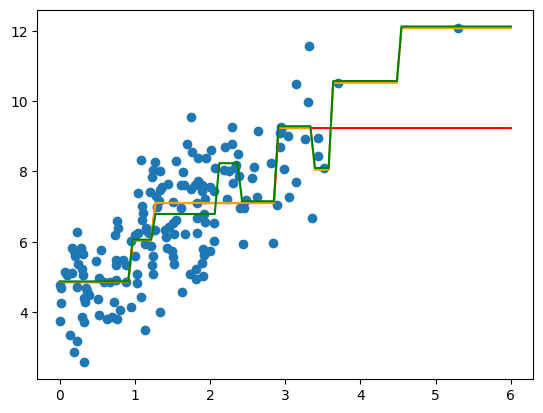

In [196]:
import matplotlib.pyplot as plt
import numpy as np

X_new = np.linspace(start=0, stop=6, num=100)
new_preds_1 = [get_prediction(x, all_trees[:1]) for x in X_new]
new_preds_2 = [get_prediction(x, all_trees[:2]) for x in X_new]
new_preds_3 = [get_prediction(x, all_trees[:3]) for x in X_new]

plt.scatter(X,y)
plt.plot(X_new, new_preds_1, c='red', label='First Tree')
plt.plot(X_new, new_preds_2, c='orange', label='Second Tree')
plt.plot(X_new, new_preds_3, c='green', label='Third Tree')
plt.show()

In [197]:
from pathlib import Path

all_trees = []
filenames = []
plt.ioff()
# Fit first tree as normal
tree = DecisionTreeRegressor(max_depth=2, random_state=42)
tree.fit(X_train, y_train)
all_trees.append(tree)
error = y_train - tree.predict(X_train)
new_preds = [get_prediction(x, all_trees) for x in X_new]
plt.scatter(X,y,c='blue')

plt.plot(X_new, new_preds, c='red', label=f'0 Tree')
plt.legend()
fn = f'tmp/photo{i}.png'
plt.savefig(fn, bbox_inches='tight')
filenames.append(fn)
plt.close()


for i in np.arange(start=1, stop=10):

    fn = f'tmp/photo{i}.png'

    tree = DecisionTreeRegressor(max_depth=2, random_state=43)
    tree.fit(X_train, error)
    all_trees.append(tree)
    error = error - tree.predict(X_train)
    new_preds = [get_prediction(x, all_trees) for x in X_new]
    plt.scatter(X,y)
    
    plt.plot(X_new, new_preds, c='red', label=f'{i} Tree')
    plt.legend()

    
    plt.savefig(fn, bbox_inches='tight')
    filenames.append(fn)
    plt.close()

In [198]:
import glob
import contextlib
from PIL import Image

fp_out = "gradient_boosting.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in filenames)

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=100, loop=20)

In [199]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=500, learning_rate=0.05, n_iter_no_change=10, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [200]:
gbrt.n_estimators_

46

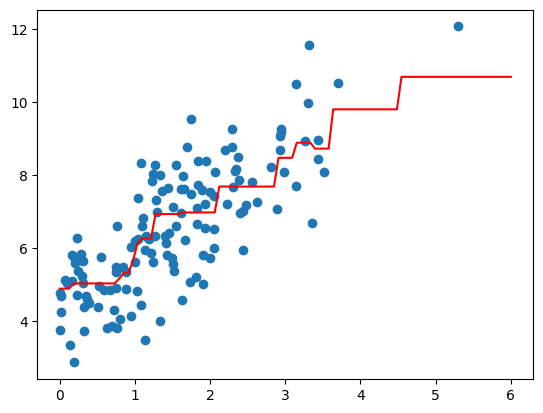

In [201]:
plt.scatter(X_train, y_train)
plt.plot(X_new, gbrt.predict(pd.DataFrame({'vehicle_tons':X_new})), c='red')
plt.show()